- Objetivo: Desarrollar una infografia georeferenciada de las votaciones del Ecuador del año del **2002**.

# Dataset obtenido del data hub USFQ 
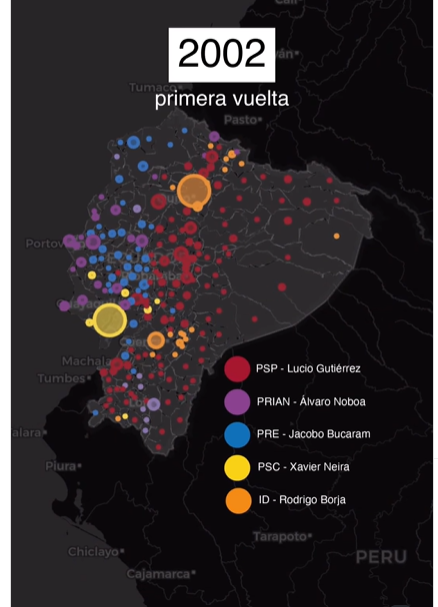

In [1]:
import folium
import pandas as pd
import geopandas as gdp
import branca
import json


## ETL del dataset

In [2]:
df = pd.read_csv("presidentes_votacion_cantonal_formato_angosto.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77462 entries, 0 to 77461
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ANIO              77462 non-null  int64 
 1   VUELTA            77462 non-null  int64 
 2   PROVINCIA_CODIGO  77462 non-null  object
 3   PROVINCIA_NOMBRE  77462 non-null  object
 4   CANTON_CODIGO     77462 non-null  object
 5   CANTON_NOMBRE     77462 non-null  object
 6   CANDIDATO_NOMBRE  77462 non-null  object
 7   AGRUPACION        77462 non-null  object
 8   VOTOS             77462 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 5.3+ MB


In [3]:
df.head()

,ANIO,VUELTA,PROVINCIA_CODIGO,PROVINCIA_NOMBRE,CANTON_CODIGO,CANTON_NOMBRE,CANDIDATO_NOMBRE,AGRUPACION,VOTOS
0,2002,1,EC01,AZUAY,EC0101,CUENCA,ALVARO NOBOA,F,7463
1,2002,1,EC01,AZUAY,EC0101,CUENCA,ALVARO NOBOA,M,6950
2,2002,1,EC01,AZUAY,EC0101,CUENCA,ALVARO NOBOA,T,14413
3,2002,1,EC01,AZUAY,EC0101,CUENCA,ANTONIO VARGAS,F,448
4,2002,1,EC01,AZUAY,EC0101,CUENCA,ANTONIO VARGAS,M,444


In [4]:
# agrupacion para obtener valos por provincia
df_gr = df.groupby(["ANIO", "VUELTA", "PROVINCIA_NOMBRE","CANDIDATO_NOMBRE","PROVINCIA_CODIGO"])["VOTOS"].sum().reset_index()
# solo datos de Ecuador continental 
df_gr = df_gr[~df_gr["PROVINCIA_NOMBRE"].isin(['EUROPA, ASIA, OCEANIA', 'NORTE-AMERICA', 'LATAM, CARIBE, AFRICA'])]
# AGRUPACION DEL 2002 Y VUELTA 1
df_gr_02 = df_gr.query("ANIO == 2002 & VUELTA == 1")
# CANDIDATOS seleccionados de la grafica
filtroCandidatos = ['ALVARO NOBOA',  'JACOBO BUCARAM','LUCIO GUTIERREZ', 
                     'RODRIGO BORJA','XAVIER NEIRA']
df_gr_02 = df_gr_02[df_gr_02.CANDIDATO_NOMBRE.isin(filtroCandidatos)]
# agrupacion por voto mayoritario en provinica
df_max = df_gr_02.loc[
    df_gr_02.groupby('PROVINCIA_NOMBRE')['VOTOS'].idxmax()
]

In [5]:
df_max.head()

,ANIO,VUELTA,PROVINCIA_NOMBRE,CANDIDATO_NOMBRE,PROVINCIA_CODIGO,VOTOS
10,2002,1,AZUAY,RODRIGO BORJA,EC01,157246
19,2002,1,BOLIVAR,LUCIO GUTIERREZ,EC02,45850
31,2002,1,CANAR,LUCIO GUTIERREZ,EC03,45386
36,2002,1,CARCHI,ALVARO NOBOA,EC04,41330
55,2002,1,CHIMBORAZO,LUCIO GUTIERREZ,EC06,114652


## Manejo del archivo .json

In [6]:
# Load Ecuador's GeoJSON data
with open("ecuador_provincias.json", "r", encoding="utf-8") as f:
    geo_json_data = json.load(f)
df_max.PROVINCIA_NOMBRE.unique()

array(['AZUAY', 'BOLIVAR', 'CANAR', 'CARCHI', 'CHIMBORAZO', 'COTOPAXI',
       'EL ORO', 'ESMERALDAS', 'GALAPAGOS', 'GUAYAS', 'IMBABURA', 'LOJA',
       'LOS RIOS', 'MANABI', 'MORONA SANTIAGO', 'NAPO', 'ORELLANA',
       'PASTAZA', 'PICHINCHA', 'SANTA ELENA', 'STO DGO TSACHILAS',
       'SUCUMBIOS', 'TUNGURAHUA', 'ZAMORA CHINCHIPE'], dtype=object)

In [7]:
# Nombre de la provincias 
nombresGjson = sorted([x['properties']["name"].upper() for x in geo_json_data['features']])
# nombres a cambiar CAÑAR ,'SANTO DOMINGO DE LOS TSÁCHILAS' cambio en el dataset
df_max["PROVINCIA_NOMBRE"] = df_max["PROVINCIA_NOMBRE"].replace({'CANAR':'CAÑAR',
                        'STO DGO TSACHILAS':'SANTO DOMINGO DE LOS TSÁCHILAS'})
df_max["PROVINCIA_NOMBRE"].unique()

array(['AZUAY', 'BOLIVAR', 'CAÑAR', 'CARCHI', 'CHIMBORAZO', 'COTOPAXI',
       'EL ORO', 'ESMERALDAS', 'GALAPAGOS', 'GUAYAS', 'IMBABURA', 'LOJA',
       'LOS RIOS', 'MANABI', 'MORONA SANTIAGO', 'NAPO', 'ORELLANA',
       'PASTAZA', 'PICHINCHA', 'SANTA ELENA',
       'SANTO DOMINGO DE LOS TSÁCHILAS', 'SUCUMBIOS', 'TUNGURAHUA',
       'ZAMORA CHINCHIPE'], dtype=object)

## Estilo del Mapa

In [8]:
# COLORES POR CANDIDATO
mapa_colores ={'ALVARO NOBOA':"#980BEF", 'JACOBO BUCARAM':"#1070B9", 'LUCIO GUTIERREZ':"#E01212",
       'RODRIGO BORJA':"#FEB00A", 'XAVIER NEIRA':"#F6FE69"}
# aplicar color al dataset
df_max['COLOR'] = df_max['CANDIDATO_NOMBRE'].apply(lambda x:mapa_colores.get(x))
df_max.head()

,ANIO,VUELTA,PROVINCIA_NOMBRE,CANDIDATO_NOMBRE,PROVINCIA_CODIGO,VOTOS,COLOR
10,2002,1,AZUAY,RODRIGO BORJA,EC01,157246,#FEB00A
19,2002,1,BOLIVAR,LUCIO GUTIERREZ,EC02,45850,#E01212
31,2002,1,CAÑAR,LUCIO GUTIERREZ,EC03,45386,#E01212
36,2002,1,CARCHI,ALVARO NOBOA,EC04,41330,#980BEF
55,2002,1,CHIMBORAZO,LUCIO GUTIERREZ,EC06,114652,#E01212


In [9]:
# OBJETIVO TENER UN COLOR POR PROVINICA PARA EL MAPA EN ESTE CASO UN DICT
color_provincia = (
    df_max.drop_duplicates('PROVINCIA_NOMBRE')
         .set_index('PROVINCIA_NOMBRE')['COLOR']
         .to_dict()
)
# OBJETIVO TENER Nombre candidato
candidatoNombre = (
    df_max.drop_duplicates('PROVINCIA_NOMBRE')
         .set_index('PROVINCIA_NOMBRE')['CANDIDATO_NOMBRE']
         .to_dict()
)

In [10]:
color_provincia

{'AZUAY': '#FEB00A',
 'BOLIVAR': '#E01212',
 'CAÑAR': '#E01212',
 'CARCHI': '#980BEF',
 'CHIMBORAZO': '#E01212',
 'COTOPAXI': '#E01212',
 'EL ORO': '#E01212',
 'ESMERALDAS': '#1070B9',
 'GALAPAGOS': '#980BEF',
 'GUAYAS': '#F6FE69',
 'IMBABURA': '#E01212',
 'LOJA': '#E01212',
 'LOS RIOS': '#1070B9',
 'MANABI': '#980BEF',
 'MORONA SANTIAGO': '#E01212',
 'NAPO': '#E01212',
 'ORELLANA': '#E01212',
 'PASTAZA': '#E01212',
 'PICHINCHA': '#FEB00A',
 'SANTA ELENA': '#980BEF',
 'SANTO DOMINGO DE LOS TSÁCHILAS': '#E01212',
 'SUCUMBIOS': '#E01212',
 'TUNGURAHUA': '#E01212',
 'ZAMORA CHINCHIPE': '#E01212'}

In [11]:
m = folium.Map(
    [-0.19899731681836336, -78.4428000494774], # PUNTO INICIAL
    tiles="Cartodb dark_matter" ,# TIPO DE ESTILO DE MAPA
    zoom_start=5) # ZOOM INICIAL
# LECTURA DEL geo_json_data OBJETO
folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        "fillColor": color_provincia.get(feature["properties"]["name"].upper(), "#808080"),
        "color": "black",
        "fillOpacity": 0.8,
    },
    tooltip=folium.GeoJsonTooltip(
            fields=["name"],
            aliases=["Provincia:"]
        )
).add_to(m)
# save del archivo
m.save("VotEcuador2002V1.html")
m

In [12]:
# Generamos dinámicamente los ítems de la leyenda
items_html = ""
for candidato, color in mapa_colores.items():
    items_html += f'''
    &nbsp; <i class="fa fa-square" style="color:{color}"></i>
    &nbsp; {candidato} <br>'''

# HTML completo para la leyenda
legend_html = f'''
{{% macro html(this, kwargs) %}}
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 250px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.9;
     padding: 10px; border-radius: 5px">
     <b>🗳️ Candidato ganador</b><br>
     {items_html}
</div>
{{% endmacro %}}
'''

# Añadimos la leyenda al mapa
legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)
m.get_root().add_child(legend)

# Guardar y mostrar
m.save('VotEcuador2002V1Legend.html')

In [13]:
m